# Practice 1: Hybrid Images

### Before starting...

#### Libraries we are going to use for this notebook

In [4]:
from skimage import io, transform, color
from scipy import ndimage, fftpack
import numpy as np
from math import pi
import matplotlib.pyplot as plt

#### Functions that we are going to use for this notebook

In [52]:
"""
This function display the images with the settings defined below. 
This funtion is used in plot_images function.

@params
    img: where we will display the image
    image: the image to display
    color_map: type of color map to display the image
    title: the title that the image will have
    axis: if we want to use or not axis, predefined as 'off'.
    
"""

def subplot_image(img, image, color_map, title="", axis="off"):
    img.axis(axis)
    img.set_title(title, fontsize=26)
    im = img.imshow(image, cmap=color_map)
    plt.colorbar(im, ax=img)


"""
This function display the images in order.

@params
    images: list of images to display
    titles: list of titles that each image will have
    color_map: list of color maps for each image
    rows: number of rows we want to use to display the images
    cols: number of columns we want to use to display the images
    axis: if we want to use or not axis, predefined as 'off'
    
"""

def plot_images(images=[],titles=[],color_map=[],rows=0,cols=0,axis='off'):
    
    # First we check if we have one cell per image
    if (rows * cols) < (len(images)):
        print(colored("Attention! The dimensions of the subplot are incorrect!","red"))
        return
    
    # Create a subplot
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(30, 15))

    # Index to acces the values of the lists (images, titles, color_map)
    index = 0 
    total = len(images)
    
    for i in range(rows):
        for j in range(cols):
            
            if index < total:
                
                if rows == 1 and cols == 1:
                    img = axs
                
                elif rows == 1:
                    img = axs[j]
                
                else:
                    img = axs[i,j]
                    
                subplot_image(img, images[index], color_map[index], titles[index], axis)
                
            else:
                image = axs[i,j]
                image.axis(axis)
                
            index += 1
    
    # Finally display the subplot
    plt.show()


"""
Function to create the gaussian filter.

@params:
    sigma: this value controls the amount of variation around mean value.
    start: start value to create our vectors
    end: finish value to create our vectors
"""

def gaussian_filter(sigma, start, end):

    # Creating 2 vectors
    x = np.linspace(start, end, sigma**2)
    y = np.linspace(start, end, sigma**2)

    # Creating rectangular grid
    x,y = np.meshgrid(x,y)

    # Applying formula (the formula is described when this function is used)
    gaussian = (1/(2 * pi * sigma**2)) * np.exp(-(x**2 + y**2)/(2 * sigma**2))

    # Normalize
    gaussian = gaussian / np.sum(gaussian)

    # Display
    plt.imshow(gaussian, cmap='jet')
    plt.colorbar()
    plt.show()
    
    return gaussian


"""
Function to convolve using the Fourier Transform.

@params:
    image: the image we want to be applied
    filt: the filter we are goinh to apply to the image (p.e. gaussian filter)
    fft_size: the size of the Fourier Transform should be a value order of 2
"""
    
def fft_filter(image, filt, sigma, fft_size=512):
    
    # Comproving at level of bits that the fft_size is order of 2
    if (fft_size & (fft_size - 1) == 0) and fft_size > 0:
        
        # Converting the image into grayscale
        img_gray = color.rgb2gray(image)

        # We apply the ff2 to the filter and the image with the fft_size
        fil_fft = fftpack.fft2(filt, (fft_size, fft_size))
        img_fft = fftpack.fft2(img_gray, (fft_size, fft_size))

        # Obtaining the filtered image in the frequence domain
        img_fil_fft = img_fft * fil_fft
        
        # Shifting inverse the image
        img_fil = fftpack.ifft2(img_fil_fft)
        
        # Obtaining the recovered image
        img_recovered = np.abs(img_fil)
        
        # Cropping the added borders
        crop = int(np.floor((sigma**2)/2))
        img_final = img_recovered[crop:image.shape[0] + crop, crop:image.shape[1] + crop]
        
        return img_final
    
    print('--Error! The fft_size value is not order of 2.--')
    return None

## Week 1: Hybrid Imaging in the Space Domain

#### Provided code
First we load the given images and crope the human image in order to match the cat image size.

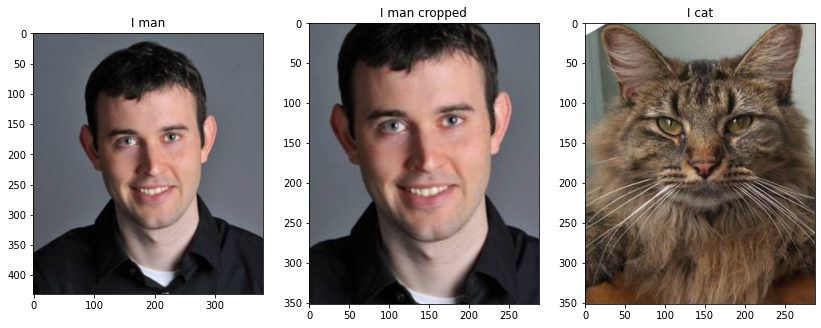

In [41]:
# Load images
img1 = io.imread('images/human.png')
img2 = io.imread('images/cat.png')

# Resize
size1 = int(round(img1.shape[0] * (4/3.)))
size2 = int(round(img1.shape[1] * (4/3.)))
img1 = transform.resize(img1, (size1, size2))

# Crop
left = 50
top = 50
right = 51 + img2.shape[0] - 1
bottom = 51 + img2.shape[1] - 1
img1_c = img1[left:right, top:bottom]

# Visualization
plt.figure(1)
plt.subplot(131)

imgplot1 = plt.imshow(img1, cmap = "gray")
plt.title('I man')
plt.subplot(132)
plt.title('I man cropped')

imgplot1 = plt.imshow(img1_c, cmap = "gray")
plt.subplot(133)
plt.title('I cat')

imgplot1 = plt.imshow(img2, cmap = "gray")
plt.gcf().set_size_inches((14,14))

#### Gaussian filter
Using the formula below we are creating our gaussian filter.
<img src="images/gaussian-filter-formula.png" style="width: 50%;">

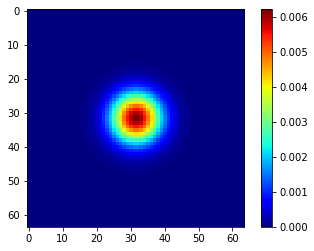

In [42]:
# The function gaussian_filter is created at the beggining of the Notebook.
# In order to create the function we used the specified formula.
gaussian = gaussian_filter(8,-50,50)

#### Images with low and high frequences
With the gaussian filter which we have created we can convolve both images. The result of the convolution of the original image will be our image with low frequencies. In order to get our high frequencies images we have to sub the original image with the low frequency image.

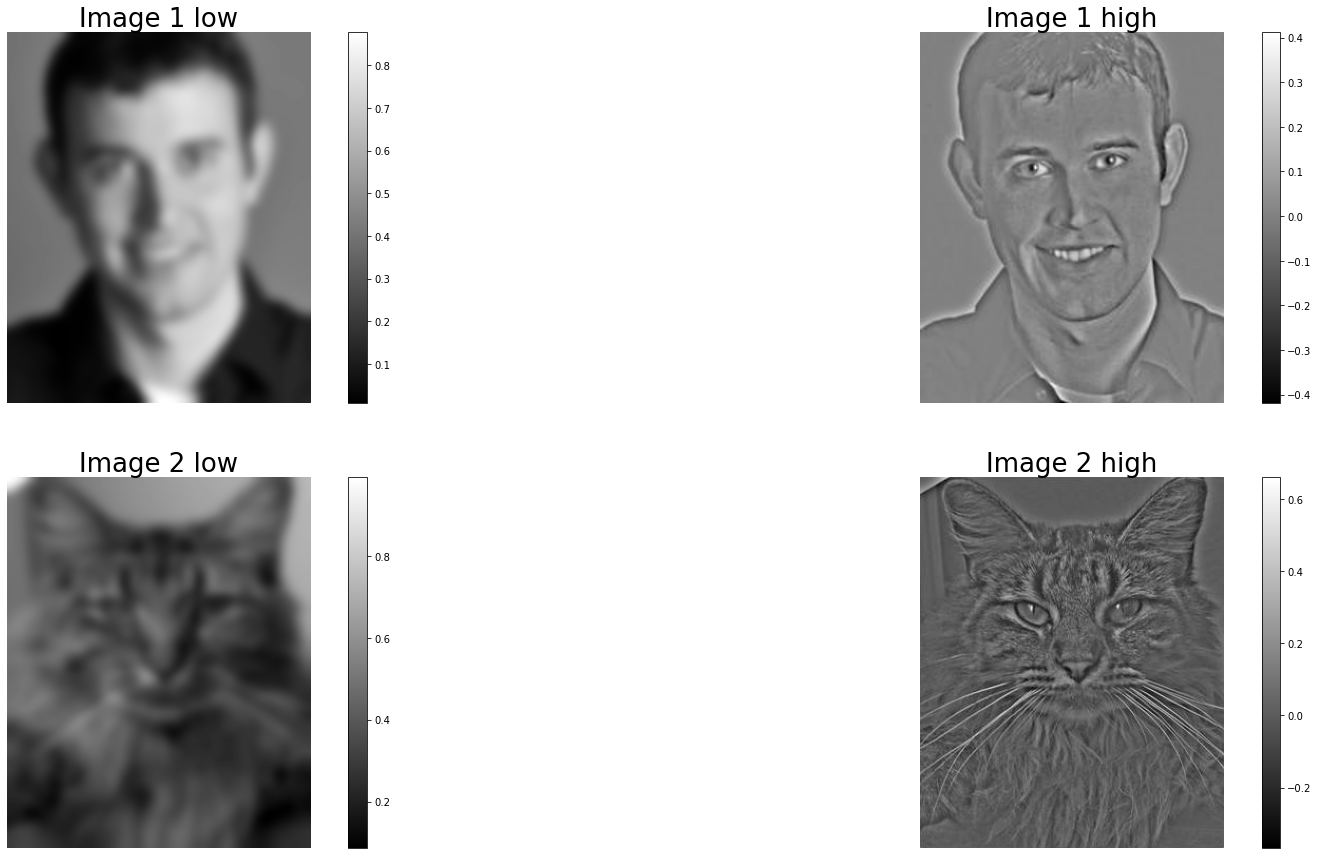

In [43]:
# Convert images to gryascale
img1_gray = color.rgb2gray(img1_c)
img2_gray = color.rgb2gray(img2)

# Convolving images
img1_low = ndimage.convolve(img1_gray, gaussian)
img2_low = ndimage.convolve(img2_gray, gaussian)

# Obtaining high frequencies
img1_high = img1_gray - img1_low
img2_high = img2_gray - img2_low

# Display images
plot_images([img1_low, img1_high, img2_low, img2_high],
            ["Image 1 low", "Image 1 high", "Image 2 low", "Image 2 high"],
            ['gray', 'gray', 'gray', 'gray'],2,2)

#### Hybrid images
Getting the hybrid images joining the low and high frequencies.

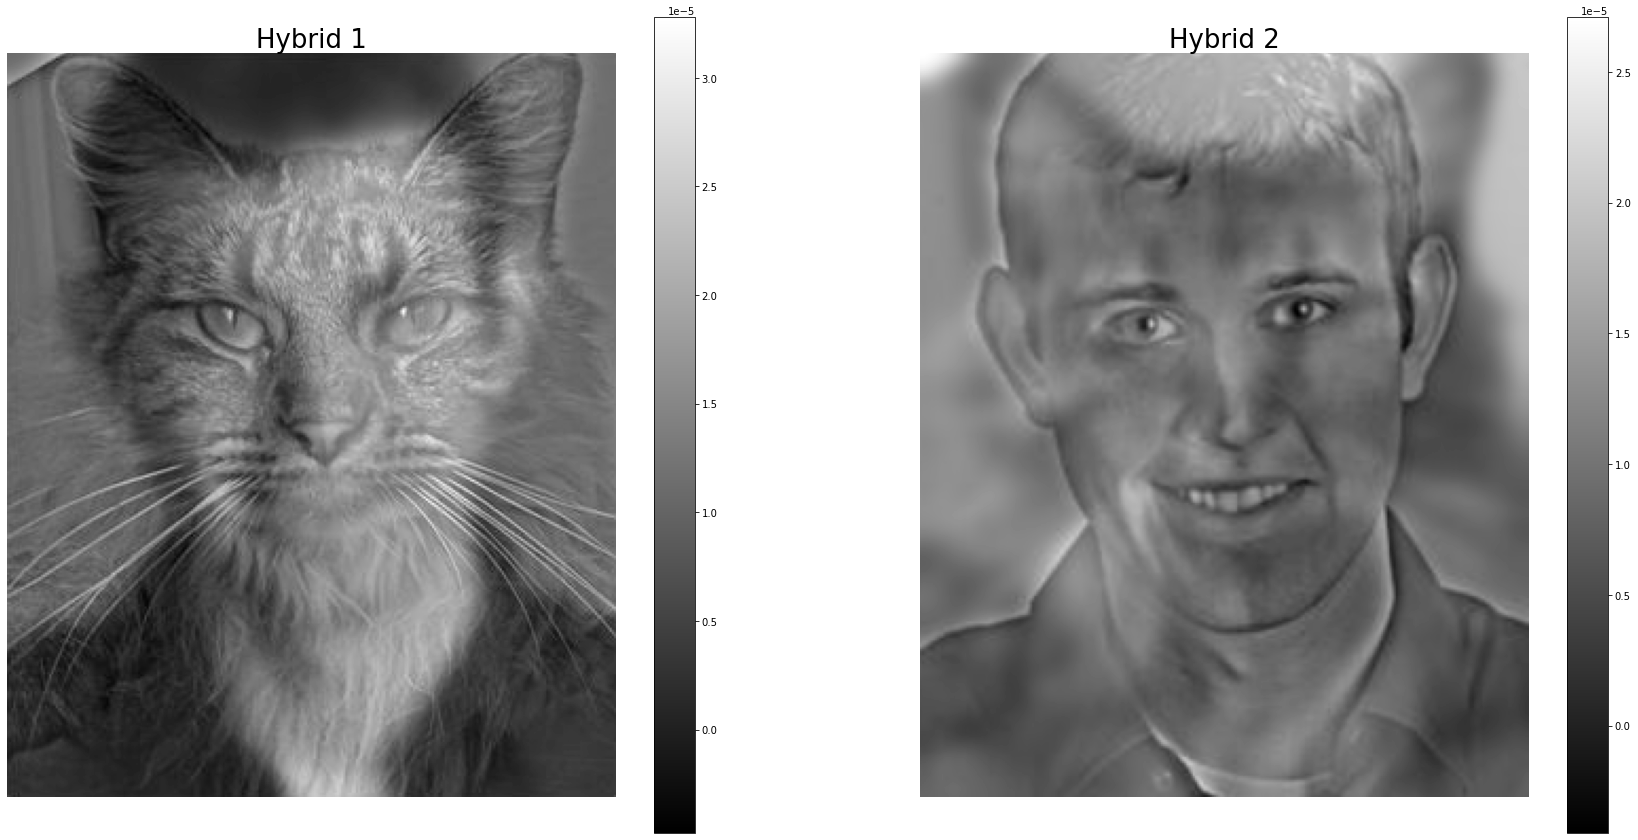

In [44]:
# Join high and low frequencies of each image
hybrid_img_1 = img1_low + img2_high
hybrid_img_2 = img1_high + img2_low

# Normalize
hybrid_1 = hybrid_img_1/(np.sum(hybrid_img_1))  
hybrid_2 = hybrid_img_2/(np.sum(hybrid_img_2))

# Display images
plot_images([hybrid_1, hybrid_2], ["Hybrid 1", "Hybrid 2"], ['gray', 'gray'],1,2)

Once we obtained our grayscale hybrid images, we can do a similar process in order to get our RGB hybrid images. In order to acomplish that we will need to separate all 3 channels and filter each one with the gaussian filter. Afterwards, we will be able to join them and have our RGB hybrid images.

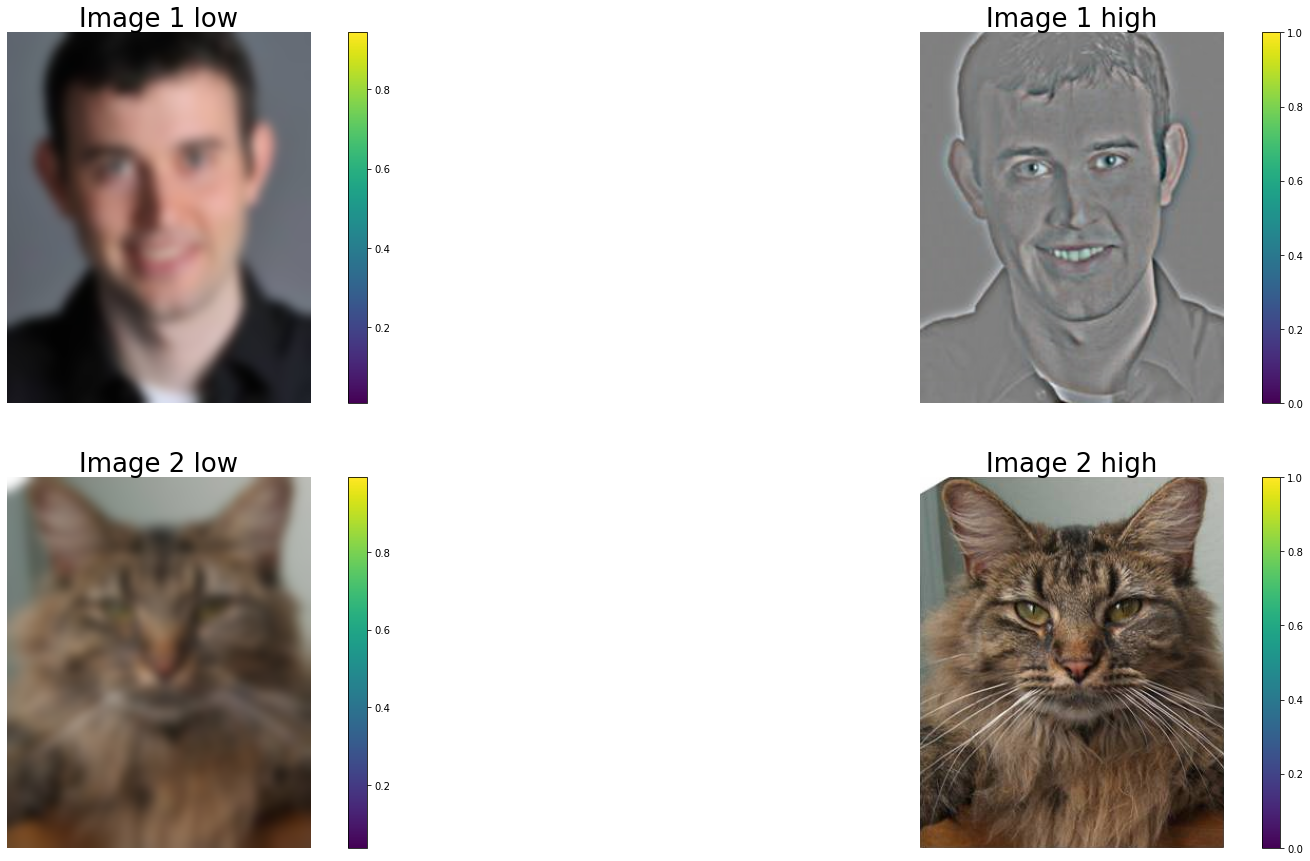

In [45]:
# Normalizing the human image before applying the gaussian filter
img1_copy = img1_c.copy()
img1_copy = (img1_copy - img1_copy.min())/(img1_copy.max() - img1_copy.min())

# Normalizing the cat image before applying the gaussian filter
img2_copy = img2.copy()
img2_copy = (img2_copy - img2_copy.min())/(img2_copy.max() - img2_copy.min())

# Convolving each channel of the human image
img1_r = ndimage.convolve(img1_copy[:, :, 0], gaussian)
img1_g = ndimage.convolve(img1_copy[:, :, 1], gaussian)
img1_b = ndimage.convolve(img1_copy[:, :, 2], gaussian)

# Convolving each channel of the cat image
img2_r = ndimage.convolve(img2_copy[:, :, 0], gaussian)
img2_g = ndimage.convolve(img2_copy[:, :, 1], gaussian)
img2_b = ndimage.convolve(img2_copy[:, :, 2], gaussian)

# Stacking the convolved channels
img1_rgb_low = np.dstack((img1_r, img1_g, img1_b))
img2_rgb_low = np.dstack((img2_r, img2_g, img2_b))

# Obtaining the high frequency image
img1_rgb_high = img1_copy - img1_rgb_low
img2_rgb_high = img2 - img2_rgb_low

# Normalize
img1_rgb_high = (img1_rgb_high - img1_rgb_high.min())/(img1_rgb_high.max() - img1_rgb_high.min())
img2_rgb_high = (img2_rgb_high - img2_rgb_high.min())/(img2_rgb_high.max() - img2_rgb_high.min())

# Display images
plot_images([img1_rgb_low, img1_rgb_high, img2_rgb_low, img2_rgb_high],
            ["Image 1 low", "Image 1 high", "Image 2 low", "Image 2 high"],
            [None, None, None, None],2,2)

In [46]:
# Join high and low frequencies of each image
hybrid_rgb_1 = img1_rgb_low + img2_rgb_high
hybrid_rgb_2 = img1_rgb_high + img2_rgb_low

# Normalize
hybrid_rgb_1 = (hybrid_rgb_1 - hybrid_rgb_1.min())/(hybrid_rgb_1.max() - hybrid_rgb_1.min())
hybrid_rgb_2 = (hybrid_rgb_2 - hybrid_rgb_2.min())/(hybrid_rgb_2.max() - hybrid_rgb_2.min())

# Display images
plot_images([hybrid_rgb_1, hybrid_rgb_2], ["Hybrid 1", "Hybrid 2"], [None, None],1,2)

## Week 2: Hybrid image in the frequency domain
For this part we will obtain the same hybrid images we got in the previous one, but we are using Fourier Transform instead. For this part, we still need the gaussian filter so we create it again.

In [47]:
# Defining only one time this values, change this value to experiment different results for different images
# fft_size is determined by the original image size
fft_size = 512
sigma = 8

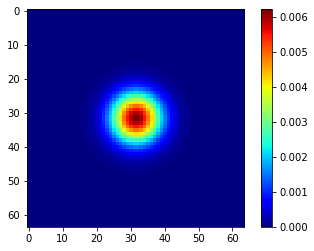

In [48]:
gaussian = gaussian_filter(sigma,-50,50)

#### Matching the size of both images
Just like in the first part, we crop the first image in order to match the size of the second image.

In [123]:
# Image from flickr, author: Saiday
img1 = io.imread('images/ball.jpg')

# Image from flickr, author: Dale Martin
img2 = io.imread('images/bulls.jpg')

"""------------ If you want to try with the images before --------------"""
# Load images
#img1 = io.imread('images/human.png')
#img2 = io.imread('images/cat.png')

# Resize
size1 = int(round(img1.shape[0] * (4/3.)))
size2 = int(round(img1.shape[1] * (4/3.)))
img1 = transform.resize(img1, (size1, size2))

# Crop
"""---------- Use this for the basketball and hat image -----------"""
left = 10
top = 90
right = 11 + img2.shape[0] - 1
bottom = 91 + img2.shape[1] - 1

"""---------- Use this for the human and cat image -------------"""
#left = 50
#top = 50
#right = 51 + img2.shape[0] - 1
#bottom = 51 + img2.shape[1] - 1

img1_c = img1[left:right, top:bottom]

# Visualization
plt.figure(1)
plt.subplot(131)

imgplot1 = plt.imshow(img1, cmap = "gray")
plt.title('Image 1')
plt.subplot(132)
plt.title('Image 1 cropped')

imgplot1 = plt.imshow(img1_c, cmap = "gray")
plt.subplot(133)
plt.title('Image 2')

imgplot1 = plt.imshow(img2, cmap = "gray")
plt.gcf().set_size_inches((14,14))

#### Obtaining the domain frequency
In order to get the domain frequency of each image and filter we need to shift them.

In [124]:
# Converting the image into grayscale
img1_gray = color.rgb2gray(img1)
img2_gray = color.rgb2gray(img2)

# We apply the ff2 to the filter and the images with the fft_size
img1_fft = fftpack.fft2(img1_gray, (fft_size, fft_size))
img2_fft = fftpack.fft2(img2_gray, (fft_size, fft_size))
fil_fft = fftpack.fft2(gaussian, (fft_size, fft_size))

# Shifting the filter and the images to the frequency domain
img1_fft_shifted = fftpack.fftshift(np.log(1 + np.abs(img1_fft)))
img2_fft_shifted = fftpack.fftshift(np.log(1 + np.abs(img2_fft)))
fil_fft_shifted = fftpack.fftshift(np.log(1 + np.abs(fil_fft)))

# Display images
plot_images([gaussian, fil_fft_shifted, img1_fft_shifted, img2_fft_shifted],
            ["Gaussian filter", "Shifted filter", "Shifted Image1", "Shifted Image2"],
            ['jet', 'jet', 'jet', 'jet'],2,2,'on')

#### Obtaining the LF and HF
We are doing a similar process (to get the low frequencies and high frequencies of both images) like in the first part, but instead of convolving the images we are using the fft filter.

In [125]:
# Convert to grayscale
img1_gray = color.rgb2gray(img1_c)
img2_gray = color.rgb2gray(img2)

# Using the function created at the beggining of the notebook in order to get the low filtered images
img1_fft_low = fft_filter(img1_c, gaussian, sigma, fft_size)
img2_fft_low = fft_filter(img2, gaussian, sigma, fft_size)

# Obtaining the high images
img1_fft_high = img1_gray - img1_fft_low
img2_fft_high = img2_gray - img2_fft_low

# Display images
plot_images([img1_fft_low, img1_fft_high, img2_fft_low, img2_fft_high],
            ["Low image 1 filtered", "High image 1 filtered", "Low image 2 filtered", "High image 2 filtered"],
            ['gray', 'gray', 'gray', 'gray'],2,2)

#### Grayscale Hybrid images
Finally we can get our grayscale hybrid images.

In [126]:
# Generate the hybrid images
hybrid_1_fft = (img1_fft_low + img2_fft_high)
hybrid_1_fft = (hybrid_1_fft - hybrid_1_fft.min())/(hybrid_1_fft.max() - hybrid_1_fft.min())

hybrid_2_fft = (img1_fft_high + img2_fft_low)
hybrid_2_fft = (hybrid_2_fft - hybrid_2_fft.min())/(hybrid_2_fft.max() - hybrid_2_fft.min())

# Display
plot_images([hybrid_1_fft, hybrid_2_fft],["Hybrid image 1", "Hybrid image 2"],['gray', 'gray'],1,2)

#### RGB Hybrid images
Following the previous steps we can obtain the RGB hybrid images. Just like in the first part we have to work with each channel separately.

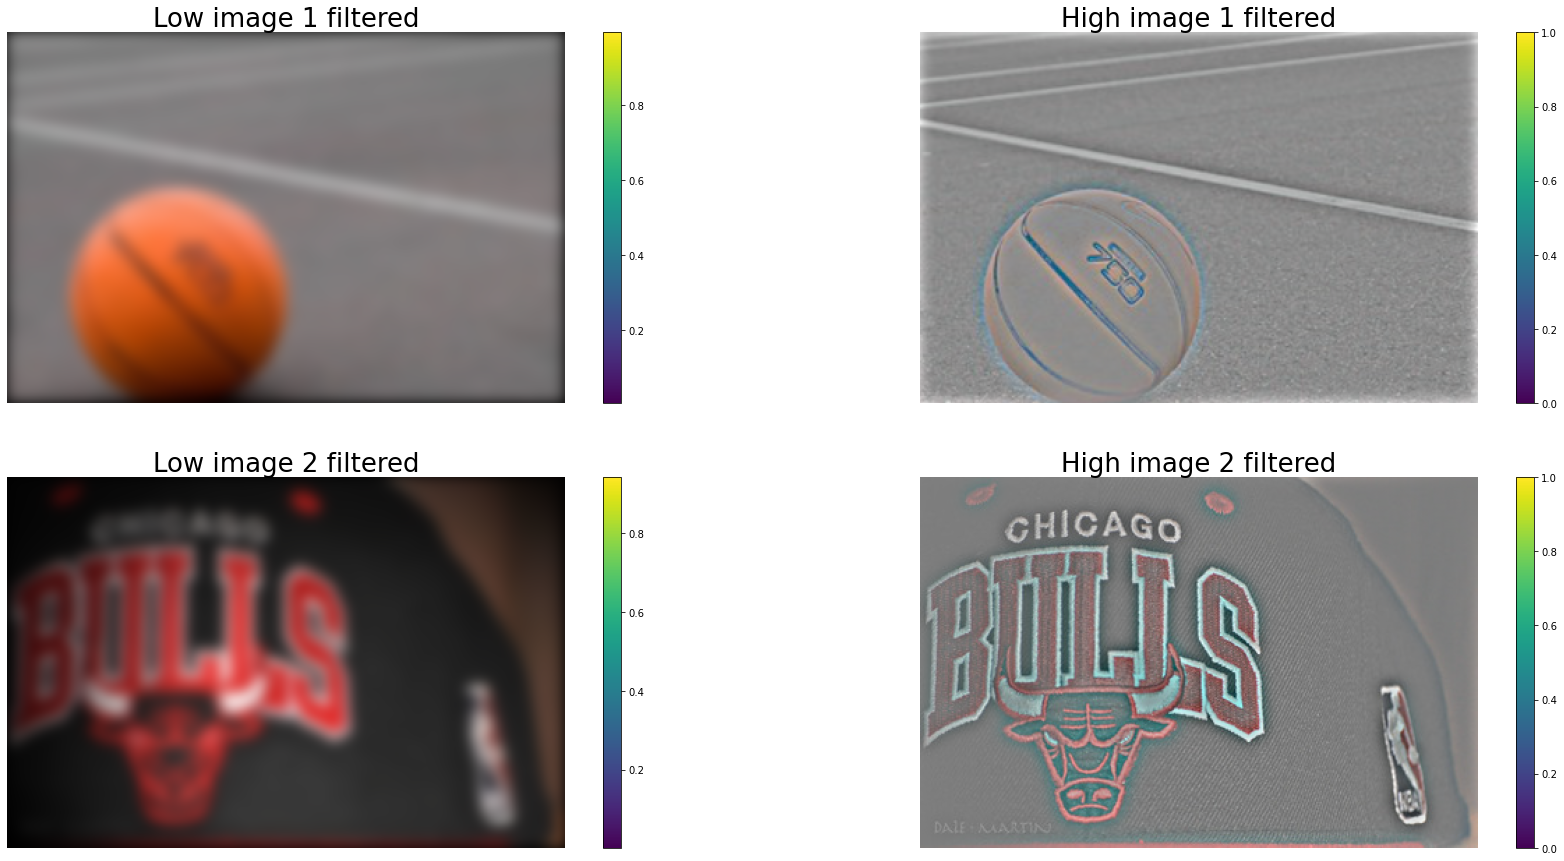

In [127]:
# Normalize the ball image
img1_fft_copy = img1_c.copy()
img1_fft_copy = (img1_fft_copy - img1_fft_copy.min())/(img1_fft_copy.max() - img1_fft_copy.min())

# Normalize the bulls image
img2_fft_copy = img2.copy()
img2_fft_copy = (img2_fft_copy - img2_fft_copy.min())/(img2_fft_copy.max() - img2_fft_copy.min())

# Filter each channel for the ball image
img1_fft_r =  fft_filter(img1_fft_copy[:, :, 0], gaussian, sigma, fft_size)
img1_fft_g = fft_filter(img1_fft_copy[:, :, 1], gaussian, sigma, fft_size)
img1_fft_b = fft_filter(img1_fft_copy[:, :, 2], gaussian, sigma, fft_size)

# Filter each channel for the bulls image
img2_fft_r =  fft_filter(img2_fft_copy[:, :, 0], gaussian, sigma, fft_size)
img2_fft_g = fft_filter(img2_fft_copy[:, :, 1], gaussian, sigma, fft_size)
img2_fft_b = fft_filter(img2_fft_copy[:, :, 2], gaussian, sigma, fft_size)

# Get the low image
img1_fft_rgb_low = np.dstack((img1_fft_r, img1_fft_g, img1_fft_b))
img2_fft_rgb_low = np.dstack((img2_fft_r, img2_fft_g, img2_fft_b))

# Get the high image of the ball image
img1_fft_rgb_high = img1_c - img1_fft_rgb_low
img1_fft_rgb_high = (img1_fft_rgb_high - img1_fft_rgb_high.min())/(img1_fft_rgb_high.max() - img1_fft_rgb_high.min())


# Get the high image of the bulls image
img2_fft_rgb_high = img2_fft_copy - img2_fft_rgb_low
img2_fft_rgb_high = (img2_fft_rgb_high - img2_fft_rgb_high.min())/(img2_fft_rgb_high.max() - img2_fft_rgb_high.min())

# Display images
plot_images([img1_fft_rgb_low, img1_fft_rgb_high, img2_fft_rgb_low, img2_fft_rgb_high],
            ["Low image 1 filtered", "High image 1 filtered", "Low image 2 filtered", "High image 2 filtered"],
            [None, None, None, None],2,2)

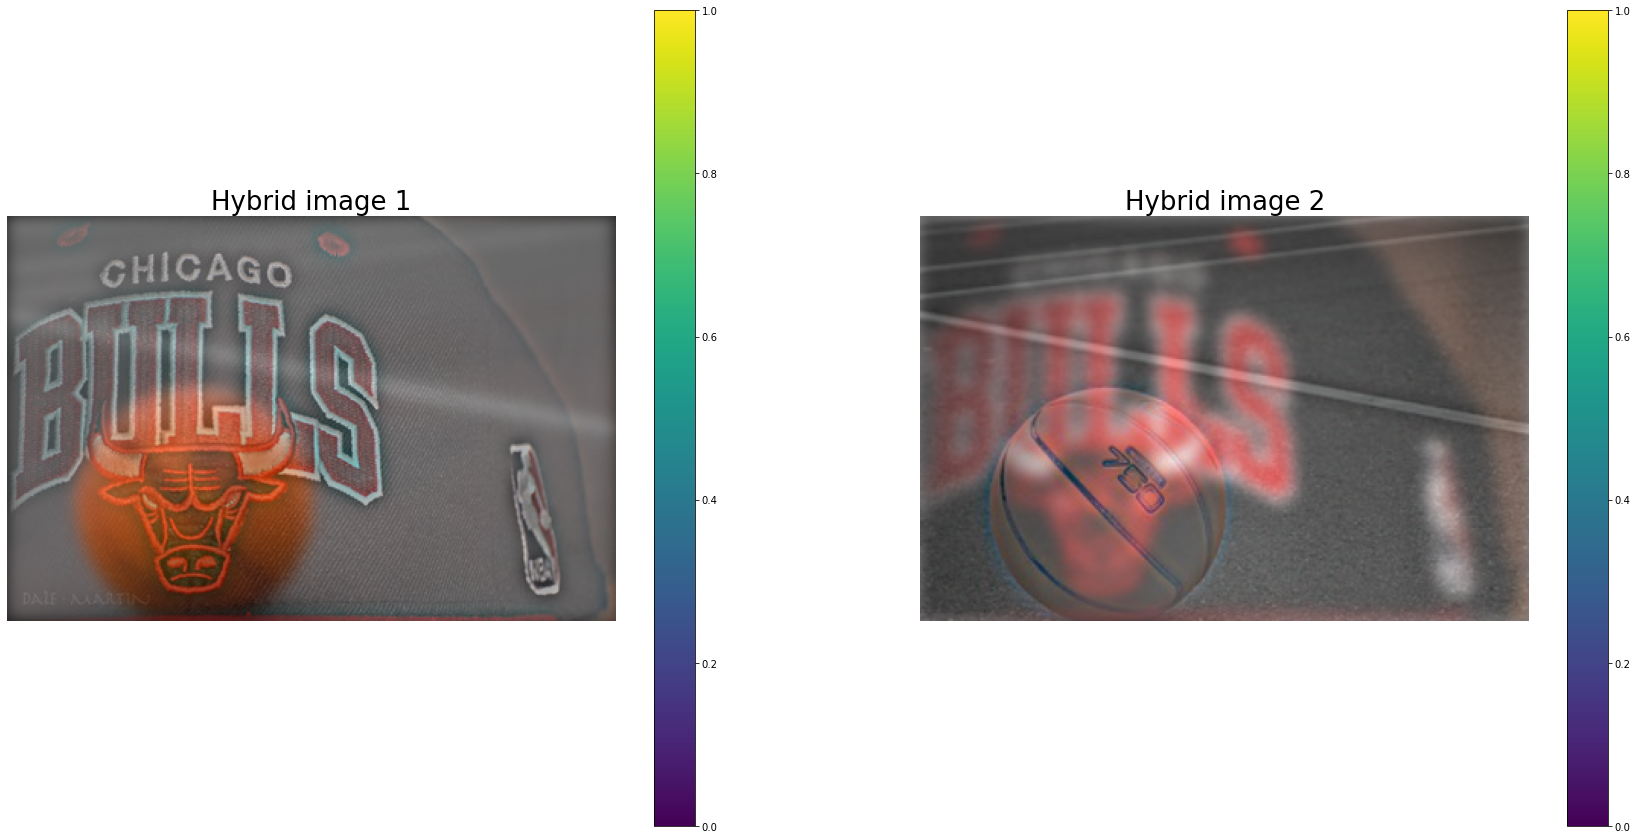

In [128]:
# Generate the hybrid images
hybrid_fft_rgb_1 = (img1_fft_rgb_low + img2_fft_rgb_high)
hybrid_fft_rgb_1 = (hybrid_fft_rgb_1 - hybrid_fft_rgb_1.min())/(hybrid_fft_rgb_1.max() - hybrid_fft_rgb_1.min())

hybrid_fft_rgb_2 = (img1_fft_rgb_high + img2_fft_rgb_low)
hybrid_fft_rgb_2 = (hybrid_fft_rgb_2 - hybrid_fft_rgb_2.min())/(hybrid_fft_rgb_2.max() - hybrid_fft_rgb_2.min())

# Display
plot_images([hybrid_fft_rgb_1, hybrid_fft_rgb_2],["Hybrid image 1", "Hybrid image 2"],[None, None],1,2)

## Question
#### Are there changes in the perception of the image if we work in grayscale or RGB?
There is not a big change in the perception of the image in my eyes, it seems that we obtain the same result just differs the colors (one is RGB and the other is grayscale). Although, maybe someone could notice a difference since the HF RGB image is not as accurate as the HF grayscale image. In other words, the color in HF RGB image varies a little and this maybe alters someones perception (it's not very significant in my eyes).

## Comparison
This 2 methods of creating hybrid images gives us really similar results, at least in my opinion the same perception. In order to see a better comparison of the images, it's recommended to comment the #load and #crop code of the basketball and hat images and discomment the human and cat images and padding.
One thing which I noticed while I was using this 2 methods, is that the convolution seems to be slowly than the FFT. In order to determinate if that is true let's make a short time computing test.

In [136]:
%%time 
# calculating the execution time of this cell
convolve_test = ndimage.convolve(color.rgb2gray(img1_c), gaussian)

CPU times: user 820 ms, sys: 24.1 ms, total: 844 ms
Wall time: 842 ms


In [137]:
%%time
# calculating the execution time of this cell
# filter image 1, resulting image has low frequencies
fft_test = fft_filter(img1_c, gaussian, sigma, fft_size)

CPU times: user 35.5 ms, sys: 303 µs, total: 35.8 ms
Wall time: 35.6 ms


Just like we supposed there is a really big difference between the execution time of both methods. At, least on my laptop the convolution is almost 25 times slower than the FFT! This is because the convolution needs to work with each pixel of the array meanwhile the FFT just applies directly the transformation to the frequency domain to to the image.